# Prototype Spatial Analytics
This notebook performs example spatial analytics that are based on interviews we conducted with Epidemiologists at Fairfax County. More details about Fairfax County Spatial Analytics use cases are documented in this Google [Doc](https://docs.google.com/document/d/1l3HAq-skWRRF_lm8Cf659uvvx7lTbBUm526-RsAse10/edit#heading=h.45gyn9vnonff).

**Note, all data in this notebook is synthetic**.

1. Dataset Requirements
    1. I assume that the dataset, in whatever format it's stored in (e.g. Parquet) can be read in some relational format. This notebook assumes dataframe in Pandas; however, R DataFrames, SAS, Stata, etc. would be analgous.
    1. For this initial use case for breakthrough infection analytics, I assume the following fields:
        1. personid (Primary Key)
        1. first_name
        1. last_name
        1. street_address
        1. zip_code
        1. latitude
        1. longitude
        1. census_tract
        1. census_block_group
        1. census_block
        1. is_fully_vax
        1. tested_covid_positive
        1. breakthrough_infection
    1. External Datasets
        1. To perform geospatial mapping, we require shapefiles of the underlying Polygons. For example, in this notebook we used Virginia's Shapefile for Census Block Groups ([Link](https://data.virginia.gov/Government/2019-Virginia-Census-Block-Groups/gtta-aa5t/data))
        1. Longer term, we may need to figure out some library to access Census shapefile data more robustly.

In [1]:
import csv
import os
import random
from random import uniform

import censusgeocode as cg 
from concurrent.futures import ThreadPoolExecutor
from faker import Faker
from geopy import Point
from geopy.distance import geodesic
import geopandas as gpd
import git
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import names
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import pyproj
pyproj.datadir.get_data_dir()
proj_4326 = pyproj.Proj(init="epsg:4326")

C:\Users\ryy0\Anaconda3\envs\prime-phdi-notebooks\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\ryy0\Anaconda3\envs\prime-phdi-notebooks\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [3]:
def get_git_root(path):
    """Return Top Level Git Repository directory given path"""
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

In [4]:
def geocode(row):
    """
    Placeholder geocoder for now, real data would come geocoded
    """
    index, lat, lng = row
    try:
        census = cg.coordinates(lng, lat)['2020 Census Blocks'][0]

        data = dict(geoid=census['GEOID'], 
                    state=census['STATE'], 
                    county=census['COUNTY'], 
                    tract=census['TRACT'], 
                    block=census['BLOCK'], 
                    lat=lat, 
                    lng=lng)

    except Exception as e:
        data = dict(lat=lat, 
                    lng=lng)

    return data

In [5]:
NOTEBOOK_PATH = os.path.abspath('')
HOME_DIR = os.path.expanduser('~')
INVENTORY_DIR = os.path.join(HOME_DIR, 'inventory')
GIT_ROOT_DIR = get_git_root(NOTEBOOK_PATH)
OUTPUTS_DIR = os.path.join(GIT_ROOT_DIR, 'src', 'notebooks', 'outputs')
FAIRFAX_COUNTY_CENTER = Point(38.845262, -77.307035)  # Approximate center of Fairfax County chosen on Google Maps

FAIRFAX_COUNTY_ZIPS = [
    22003, 22030, 20171, 22015, 20170, 20120, 22033, 22309, 22079,
    22306, 22031, 22042, 22312, 22310, 22153, 22032, 22315, 22152,
    20191, 20121, 22101, 22150, 22041, 22182, 22043, 20151, 22180,
    22102, 22311, 20190, 22124, 22046, 22151, 22039, 22066, 20124,
    22303, 22181, 22308, 22044, 20194, 22307, 22060, 22027, 22185,
    22035, 22081, 22092, 22082, 22095, 22096, 22103, 22107, 22106,
    22109, 22108, 22118, 22116, 22120, 22119, 22122, 22121, 22158,
    22156, 22160, 22159, 22161, 22183, 22184, 22199, 22009, 22037,
    22036, 22047, 22067, 20122, 20153, 20172, 20193, 20192, 20195,
    20196, 20511
]

In [6]:
def generate_point(center: Point, radius: int) -> Point:
    """
    This is from
    
    https://stackoverflow.com/questions/31192451/generate-random-geo-coordinates-within-specific-radius-from-seed-point
    """
    radius_in_kilometers = radius * 1e-3
    random_distance = random.random() * radius_in_kilometers
    random_bearing = random.random() * 360
    return geodesic(kilometers=random_distance).destination(center, random_bearing)

In [7]:
def write_points(points, filename='synthetic_locations.csv'):
    """
    Output a CSV so that you can upload to Google Maps to just check the synthetic points
    """
    with open(os.path.join(OUTPUTS_DIR, filename), 'w', encoding='UTF8', newline="") as f:
        writer = csv.writer(f)
        writer.writerow(['latitude', 'longitude'])
        for p in points:
            writer.writerow([p[0], p[1]])

In [8]:
radius = 20000  # By default this is in meters
number_of_points = 10000
center = FAIRFAX_COUNTY_CENTER
points = [generate_point(center, radius) for _ in range(number_of_points)]

write_points(points)

In [9]:
# Generating the synthetic data as a dataframe
latitudes = []
longitudes = []
personids = random.sample(range(len(points)), len(points))
first_names = []
last_names = []
addresses = []
fake = Faker()
zip_codes = []
for p in points:
    latitudes.append(p[0])
    longitudes.append(p[1])
    address = fake.address()
    street = address.split('\n')[0]
    first_names.append(names.get_first_name())
    last_names.append(names.get_last_name())
    addresses.append(street)
    zip_codes.append(random.sample(FAIRFAX_COUNTY_ZIPS, 1)[0])

In [10]:
df = pd.DataFrame({
    'personid': personids,
    'first_name': first_names,
    'last_name': last_names,
    'street_address': addresses,
    'zip_code': zip_codes,
    'latitude': latitudes,
    'longitude': longitudes,
}) 

In [11]:
with ThreadPoolExecutor() as tpe:
     data = list(tqdm(tpe.map(geocode, df[['latitude', 'longitude']].itertuples()), total=len(df)))
data_df = pd.DataFrame.from_records(data)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
data_df.head()

,geoid,state,county,tract,block,lat,lng
0,510594816001009,51,059,481600,1009,38.900354,-77.338963
1,516003004003006,51,600,300400,3006,38.839155,-77.313235
2,510594901053000,51,059,490105,3000,38.866349,-77.452588
3,511539017021006,51,153,901702,1006,38.791109,-77.464158
4,510594323003004,51,059,432300,3004,38.776672,-77.283664


In [13]:
df['census_tract'] = data_df['state'] + data_df['county'] + data_df['tract']
df['census_block_group'] = data_df['state'] + data_df['county'] + data_df['tract'] + data_df['block'].str[0]
df['census_block'] = data_df['geoid']

In [14]:
def generate_covid_positive(row):
    if row['is_fully_vax'] == 0:
        covid_positive = random.choices([0, 1], weights=(0.97, 0.03), k=1)
        return covid_positive[0]
    else:
        covid_positive = random.choices([0, 1], weights=(0.99, 0.01), k=1)
        return covid_positive[0]

is_fully_vax = random.choices([0, 1], weights=(0.4, 0.6), k=len(points))
df['is_fully_vax'] = is_fully_vax
df['tested_covid_positive'] = df.apply(lambda row: generate_covid_positive(row), 1)
df['breakthrough_infection'] = df['is_fully_vax'] * df['tested_covid_positive']

In [15]:
df.head()

,personid,first_name,last_name,street_address,zip_code,latitude,longitude,census_tract,census_block_group,census_block,is_fully_vax,tested_covid_positive,breakthrough_infection
0,7176,Doris,Stevens,864 Zachary Cliffs,22185,38.900354,-77.338963,51059481600,510594816001,510594816001009,1,0,0
1,5608,Shirley,Mcghee,4319 Natalie Hills Suite 134,22151,38.839155,-77.313235,51600300400,516003004003,516003004003006,0,0,0
2,9703,Jose,Kelleher,1810 Jennifer Road,22312,38.866349,-77.452588,51059490105,510594901053,510594901053000,0,0,0
3,4659,Brenda,Gaydos,8474 Denise Mountain Suite 973,22183,38.791109,-77.464158,51153901702,511539017021,511539017021006,0,0,0
4,23,Marie,Baker,0704 Brown Garden Suite 002,20193,38.776672,-77.283664,51059432300,510594323003,510594323003004,0,0,0


# Spatial Analytics

I found this Medium [Post](https://towardsdatascience.com/mapping-census-data-fbab6722def0) and [notebook](https://github.com/allisoncstafford/seattle_tree_canopy_blog/blob/master/census_ethnicity.ipynb) to be helpful

In [16]:
virginia_map = gpd.read_file(os.path.join(INVENTORY_DIR, '2019 Virginia Census Block Groups', 'geo_export_64de6806-7ef0-4c39-97f1-b52e5d986702.shp'))
fairfax_map = virginia_map.loc[virginia_map.countyfp == '059']

In [17]:
virginia_map.head()

,statefp,countyfp,tractce,blkgrpce,geoid,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,51,550,020807,2,515500208072,Block Group 2,G5030,S,1106271.0,145336.0,+36.7565623,-076.2151700,"POLYGON ((-76.21963 36.75324, -76.21959 36.753..."
1,51,680,000801,1,516800008011,Block Group 1,G5030,S,1722142.0,0.0,+37.3996793,-079.1740345,"POLYGON ((-79.18514 37.39511, -79.18479 37.395..."
2,51,680,000802,2,516800008022,Block Group 2,G5030,S,820074.0,9100.0,+37.3923867,-079.1928460,"POLYGON ((-79.19633 37.39872, -79.19632 37.398..."
3,51,680,000802,3,516800008023,Block Group 3,G5030,S,863596.0,0.0,+37.3846711,-079.1897255,"POLYGON ((-79.19507 37.38897, -79.19475 37.389..."
4,51,680,000900,3,516800009003,Block Group 3,G5030,S,984535.0,0.0,+37.3816830,-079.1966871,"POLYGON ((-79.20623 37.38548, -79.20622 37.385..."


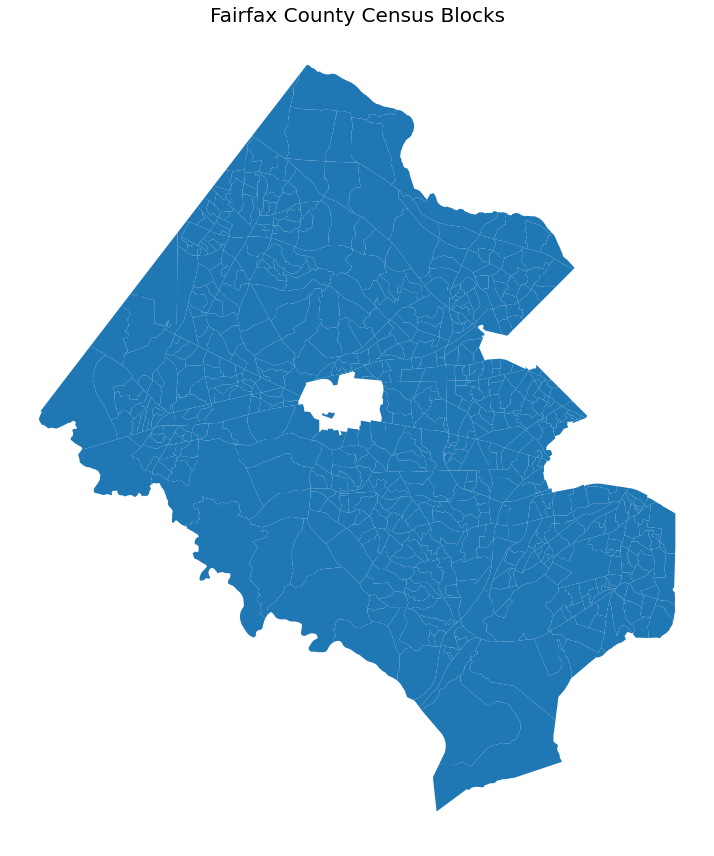

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
fairfax_map.plot(ax=ax)
ax.set_title('Fairfax County Census Blocks', fontsize=20)
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
# plt.savefig('images/crs.png')

In [19]:
# Creating a simple breakthrough metric
df_agg = df.groupby(['census_block_group'], as_index=False).agg({
    'personid': 'count',
    'is_fully_vax': np.sum,
    'tested_covid_positive': np.sum,
    'breakthrough_infection': np.sum,
})
df_agg.rename(columns={'personid': 'number_of_people'}, inplace=True)
df_agg['infection_rate'] = df_agg['tested_covid_positive'] / df_agg['number_of_people']
df_agg['breakthrough_infection_rate'] = df_agg['breakthrough_infection'] / df_agg['is_fully_vax']


In [20]:
fairfax_map = fairfax_map.merge(
    right=df_agg[['census_block_group', 'infection_rate', 'breakthrough_infection_rate']],
    left_on='geoid',
    right_on='census_block_group',
)

In [21]:
fairfax_map.head()

,statefp,countyfp,tractce,blkgrpce,geoid,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry,census_block_group,infection_rate,breakthrough_infection_rate
0,51,059,491301,4,510594913014,Block Group 4,G5030,S,888139.0,22043.0,+38.8327371,-077.4561649,"POLYGON ((-77.46823 38.83219, -77.46809 38.832...",510594913014,0.0,0.0
1,51,059,420201,3,510594202013,Block Group 3,G5030,S,262347.0,0.0,+38.7861269,-077.1393629,"POLYGON ((-77.14277 38.78809, -77.14183 38.788...",510594202013,0.0,NaN
2,51,059,420300,2,510594203002,Block Group 2,G5030,S,1601602.0,723.0,+38.7966477,-077.1028741,"POLYGON ((-77.11120 38.79934, -77.11097 38.799...",510594203002,0.0,0.0
3,51,059,420300,3,510594203003,Block Group 3,G5030,S,613770.0,0.0,+38.8012148,-077.0969745,"POLYGON ((-77.11221 38.80207, -77.11208 38.802...",510594203003,0.0,0.0
4,51,059,431802,2,510594318022,Block Group 2,G5030,S,412863.0,0.0,+38.8128449,-077.2720159,"POLYGON ((-77.27726 38.81075, -77.27724 38.810...",510594318022,0.0,0.0


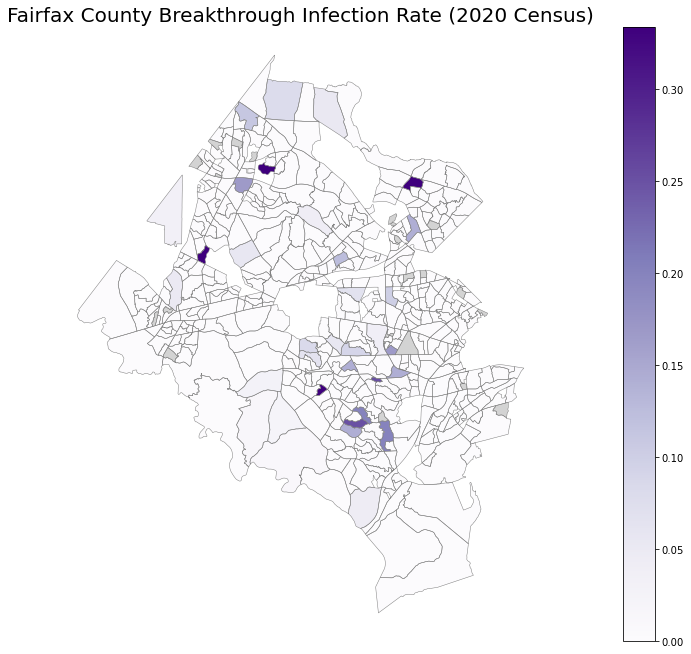

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fairfax_map.plot(
    ax=ax, 
    column='breakthrough_infection_rate', 
    cmap='Purples',
    legend=True, 
    cax=cax,
    missing_kwds={"color": "lightgrey"},
)
fairfax_map.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=.5)
ax.set_title('Fairfax County Breakthrough Infection Rate (2020 Census)', fontsize=20)
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
# plt.savefig('images/choropleth.png')

In [23]:
df_agg.describe()

,number_of_people,is_fully_vax,tested_covid_positive,breakthrough_infection,infection_rate,breakthrough_infection_rate
count,897.000000,897.000000,897.000000,897.000000,897.000000,826.000000
mean,11.148272,6.655518,0.193980,0.062430,0.015759,0.009909
std,18.850838,11.347030,0.524242,0.255528,0.060135,0.058192
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,11.000000,7.000000,0.000000,0.000000,0.000000,0.000000
max,177.000000,110.000000,4.000000,2.000000,1.000000,1.000000


<AxesSubplot:>

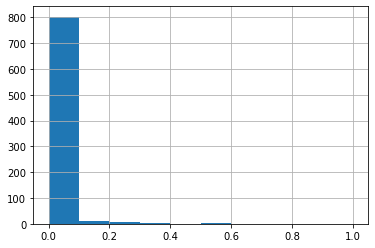

In [32]:
df_agg.breakthrough_infection_rate.hist()